In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport utils, Networks

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from utils import load_embeddings_and_ids, concatenate_featmats, plot_images

### Loading Features

In [4]:
resnet50 = load_embeddings_and_ids('/mnt/workspace/Ugallery/ResNet50/', 'flatten_1.npy', 'ids')

In [5]:
alexnet = load_embeddings_and_ids('/mnt/workspace/Ugallery/AlexNet/', 'fc7.npy', 'ids.npy')

In [6]:
inceptionv3 = load_embeddings_and_ids('/mnt/workspace/Ugallery/InceptionV3/', 'avg_pool.npy', 'ids')

In [7]:
vgg19 = load_embeddings_and_ids('/mnt/workspace/Ugallery/VGG19/', 'fc2.npy', 'ids')

In [8]:
incepresv2 = load_embeddings_and_ids('/mnt/workspace/Ugallery/InceptionResnetV2/', 'avg_pool.npy', 'ids')

In [9]:
embedding_list = [resnet50, alexnet, inceptionv3, vgg19, incepresv2]

### Combining features and applying PCA

In [10]:
artwork_ids = set()
artwork_ids.update(resnet50['index2id'])
artwork_ids.intersection_update(alexnet['index2id'])
artwork_ids.intersection_update(inceptionv3['index2id'])
artwork_ids.intersection_update(vgg19['index2id'])
artwork_ids.intersection_update(incepresv2['index2id'])

In [11]:
len(artwork_ids)

13297

In [12]:
featmat_list = [tmp['featmat'] for tmp in embedding_list]
id2index_list = [tmp['id2index'] for tmp in embedding_list]
concat_featmat = concatenate_featmats(artwork_ids, featmat_list, id2index_list)

In [13]:
concat_featmat.shape

(13297, 13824)

In [14]:
std_scaler = StandardScaler()

In [15]:
concat_featmat_zscored = std_scaler.fit_transform(concat_featmat)

In [16]:
pca200_concat = PCA(n_components=200).fit_transform(concat_featmat_zscored)

In [17]:
pca200_concat.shape

(13297, 200)

In [22]:
from os import makedirs
dirpath = '/mnt/workspace/Ugallery/PCA200(resnet50+alexnet+inceptionv3+vgg19+incepresv2)/'
makedirs(dirpath, exist_ok=True)
np.save(dirpath + 'embeddings.npy', pca200_concat)
np.save(dirpath + 'ids.npy', np.array(list(artwork_ids)))

### K-Means Clustering

In [66]:
best_score=None
best_clusterer=None

In [ ]:
for _ in range(20):
    print(_,' ---------------------------------')
    clusterer = KMeans(n_clusters=100, max_iter=1200).fit(pca200_concat)
    cluster_labels = clusterer.predict(pca200_concat)
    silhouette_avg = silhouette_score(pca200_concat, cluster_labels)
    if best_score is None or best_score < silhouette_avg:
        best_score = silhouette_avg
        best_clusterer = clusterer
    print("Average silhouette_score is :", silhouette_avg)

In [69]:
index2id = list(artwork_ids)

In [70]:
best_cluster_labels = best_clusterer.predict(pca200_concat)

In [71]:
silhouette_score(pca200_concat, best_cluster_labels)

0.043388232237469945

In [72]:
artwork_id_2_cluster_id = { aid:int(cid) for aid,cid in zip(index2id, best_cluster_labels) }

In [73]:
import json
from os import makedirs
makedirs('/mnt/workspace/Ugallery/Clustering/', exist_ok=True)
with open('/mnt/workspace/Ugallery/Clustering/artworkId2clusterId(resnet50+alexnet+inceptionv3+vgg19+incepresv2).json',
          'w') as f:
    json.dump(artwork_id_2_cluster_id, f)

### Visualize Clusters

In [74]:
import random
import matplotlib.pyplot as plt

In [75]:
N_CLUSTERS = 100

In [76]:
image_cache = dict()

In [77]:
artwork_ids_by_cluster = {i:[] for i in range(N_CLUSTERS)}
for aid,cid in artwork_id_2_cluster_id.items():
    artwork_ids_by_cluster[cid].append(aid)
for i in range(N_CLUSTERS):
    assert len(artwork_ids_by_cluster[i]) > 0

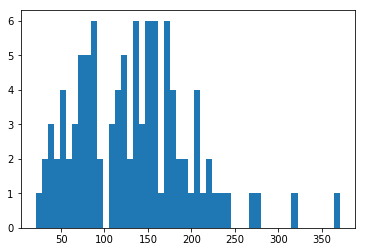

In [78]:
plt.hist([len(x) for x in artwork_ids_by_cluster.values()], bins=50)
plt.show()

In [79]:
def plot_image_sample(cluster_id=None, n_samples=20, n_clusters=100):
    if cluster_id is None:
        cluster_id = np.random.randint(n_clusters)
        
    ids = artwork_ids_by_cluster[cluster_id]
    if len(ids) > n_samples:
        sample_ids = random.sample(ids, n_samples)
    else:
        sample_ids = ids
    n = len(sample_ids)
    
    print('----- cluster_id = %d, size = %d ------' % (cluster_id, len(ids)))
        
    plot_images(plt, image_cache, sample_ids)

----- cluster_id = 66, size = 208 ------


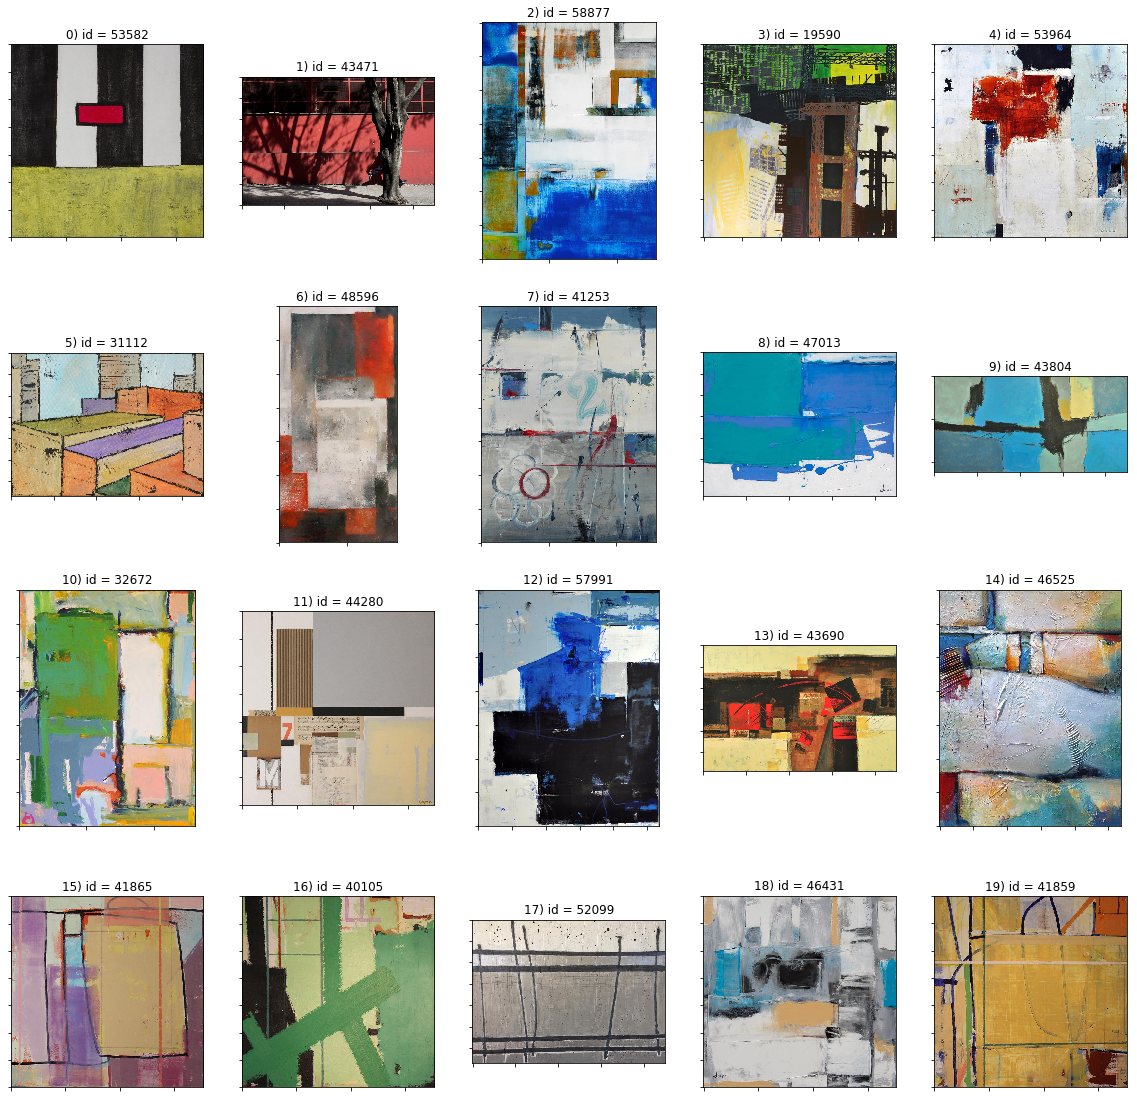

In [94]:
plot_image_sample(cluster_id=None, n_samples=20)